In [64]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

class SolarLSTMPredictor:
    def __init__(self, seq_length=72, target_col="value"):
        """
        Initialize the predictor configuration
        """
        self.seq_length = seq_length
        self.target_col = target_col
        self.model = None
        self.scaler_x = None
        self.scaler_y = None
        
        self.features = [
            "shortwave_radiation", "direct_radiation", "diffuse_radiation",
            "direct_normal_irradiance", "cloudcover", "cloudcover_low",
            "cloudcover_mid", "cloudcover_high", "temperature_2m",
            "relativehumidity_2m", "solar_count", "dewpoint_2m",
            "surface_pressure", "time", "rain", "season",
            "day", "month", "sunrise_time_h", "sunrise_time_m",
            "sunset_time_h", "sunset_time_m", "sin_time",
            "cos_time", "day_of_month_sin", "day_of_month_cos",
            "month_of_year_sin", "month_of_year_cos",
        ]


    def load_artifacts(self, model_path, scaler_x_path, scaler_y_path):
        """
        โหลด Model และ Scaler จากไฟล์
        """
        if not all(os.path.exists(p) for p in [model_path, scaler_x_path, scaler_y_path]):
            raise FileNotFoundError("One or more artifact files not found.")
            
        try:
            self.model = load_model(model_path)
            self.scaler_x = joblib.load(scaler_x_path)
            self.scaler_y = joblib.load(scaler_y_path)
            print("✅ Model and Scalers loaded successfully.")
        except Exception as e:
            raise RuntimeError(f"Failed to load artifacts: {e}")


    def _preprocess(self, df):

        if self.scaler_x is None:
            raise ValueError("Scalers not loaded. Call load_artifacts() first.")

        # 1. Feature Selection & Check
        missing = [c for c in self.features if c not in df.columns]
        if missing:
            raise ValueError(f"Missing columns in input data: {missing}")
            
        df_selected = df[self.features].copy()

        # 2. Handle NaNs (Time series interpolation)
        df_selected = df_selected.ffill().bfill()
        
        # 3. Scaling (Transform only)
        X_values = df_selected.values.astype(float)
        X_scaled = self.scaler_x.transform(X_values)

        # 4. Create Sequences
        # ถ้าข้อมูลน้อยกว่า SEQ_LENGTH จะทำนายไม่ได้
        if len(X_scaled) <= self.seq_length:
            return None, None
            
        X_seq = []
        for i in range(len(X_scaled) - self.seq_length):
            X_seq.append(X_scaled[i : i + self.seq_length])
            
        return np.array(X_seq).astype("float32"), df.iloc[self.seq_length:].copy()

    def predict(self, df_test, return_actual=True):
        """
        Main method: รับ DataFrame -> คืนค่า DataFrame ที่มีผลทำนาย
        """
        if self.model is None:
            raise ValueError("Model not loaded. Call load_artifacts() first.")
            
        print(f"Processing {len(df_test)} rows...")
        
        # Preprocess Data
        X_seq, result_df = self._preprocess(df_test)
        
        if X_seq is None:
            print(f"⚠️ Not enough data. Need more than {self.seq_length} rows.")
            return None

        # Prediction
        print("Predicting...")
        y_pred_scaled = self.model.predict(X_seq, verbose=0)
        
        # Inverse Scale
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled)
        y_pred = np.clip(y_pred, a_min=0.0, a_max=None) # Solar power ไม่ควรติดลบ

        # Assign results back to DataFrame
        result_df = result_df.reset_index(drop=True)
        result_df["Predicted_Power"] = y_pred.flatten()

        # Compare with Actual (if available)
        if return_actual and self.target_col in df_test.columns:

            actual_values = df_test[self.target_col].values[self.seq_length:]
            result_df["Actual_Power"] = actual_values
            
            mae = np.mean(np.abs(result_df["Actual_Power"] - result_df["Predicted_Power"]))
            print(f"Test Set MAE: {mae:.4f}")

        return result_df

In [47]:
# ==========================================
# วิธีการใช้งาน (Usage Example)
# ==========================================

# 1. สร้าง Instance ของ Class
predictor = SolarLSTMPredictor(seq_length=1)

# 2. โหลดไฟล์ (แก้ path ให้ตรงกับเครื่องคุณ)
predictor.load_artifacts(
    model_path="./model/weights_lstm/solar/solar_lstm_model.keras",
    scaler_x_path="./model/weights_lstm/solar/solar_scaler_x.joblib",
    scaler_y_path="./model/weights_lstm/solar/solar_scaler_y.joblib"
)

✅ Model and Scalers loaded successfully.


In [12]:
from db.duckdb import get_duckdb_connection, duckQueryDF

In [14]:
con = get_duckdb_connection()

In [ ]:
query = "SELECT * FROM main.retrain_data where fueltype = 1"

df_solar = duckQueryDF(query)

In [51]:
df_solar

,time,date,day,month,year,fueltype,type-name,solar_count,wind_turbine_count,value,...,sunrise_time_h,sunrise_time_m,sunset_time_h,sunset_time_m,sin_time,cos_time,day_of_month_sin,day_of_month_cos,month_of_year_sin,month_of_year_cos
0,0,2025-11-20,20,11,2025,1,Solar,65.43,2593,9733,...,6,41,16,44,0.000000,1.000000,-0.790776,-0.612106,-0.5,0.866025
1,0,2025-11-20,20,11,2025,2,Wind,65.43,2593,548,...,6,41,16,44,0.000000,1.000000,-0.790776,-0.612106,-0.5,0.866025
2,1,2025-11-20,20,11,2025,1,Solar,65.43,2593,6249,...,6,41,16,44,0.258819,0.965926,-0.790776,-0.612106,-0.5,0.866025
3,1,2025-11-20,20,11,2025,2,Wind,65.43,2593,448,...,6,41,16,44,0.258819,0.965926,-0.790776,-0.612106,-0.5,0.866025
4,2,2025-11-20,20,11,2025,1,Solar,65.43,2593,770,...,6,41,16,44,0.500000,0.866025,-0.790776,-0.612106,-0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,22,2025-11-21,21,11,2025,2,Wind,65.43,2593,1598,...,6,42,16,44,-0.500000,0.866025,-0.897805,-0.440394,-0.5,0.866025
94,23,2025-11-21,21,11,2025,1,Solar,65.43,2593,5035,...,6,42,16,44,-0.258819,0.965926,-0.897805,-0.440394,-0.5,0.866025
95,23,2025-11-21,21,11,2025,2,Wind,65.43,2593,1658,...,6,42,16,44,-0.258819,0.965926,-0.897805,-0.440394,-0.5,0.866025
96,0,2025-11-22,22,11,2025,1,Solar,65.43,2593,4234,...,6,43,16,43,0.000000,1.000000,-0.968077,-0.250653,-0.5,0.866025


In [54]:
df_solar = df_solar[df_solar['fueltype'] == 1]

In [55]:
len(test_data)

98

In [60]:
from datasets import load_dataset
dataset_dict = load_dataset("wachawich/REG-Forecasting_v2")
dataset = dataset_dict["train"]
df = dataset.to_pandas()
df_solar_test = df[df["fueltype"] == 1].reset_index(drop=True)

In [65]:
df_solar = df_solar_test[len(df_solar_test) - 192:]

Processing 192 rows...
Predicting...
Test Set MAE: 3720.9096
len(results) 191


,time,Predicted_Power,Actual_Power
0,2,5253.669922,988
1,3,4743.392090,-54
2,4,4312.642090,-59
3,5,4050.011719,-55
4,6,3829.334473,-58
...,...,...,...
186,20,8021.937988,9734
187,21,8009.949707,10029
188,22,7870.277344,10146
189,23,7691.384277,10192


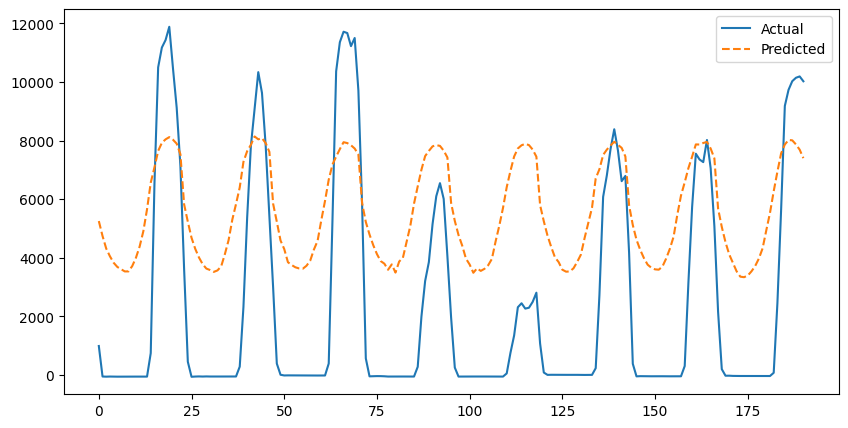

In [66]:
# 3. ลองทำนาย (สมมติว่ามี df_solar อยู่แล้ว)
if 'df_solar' in locals():
    # ลองตัดข้อมูลมาทำนาย
    test_data = df_solar
    
    results = predictor.predict(test_data, return_actual=True)
    results["diff"] = results["Actual_Power"] - results["Predicted_Power"]
    print("len(results)",len(results))
    
    if results is not None:
        display(results[["time", "Predicted_Power", "Actual_Power"]])
        
        # Plot กราฟ
        plt.figure(figsize=(10, 5))
        plt.plot(results["Actual_Power"], label="Actual")
        plt.plot(results["Predicted_Power"], label="Predicted", linestyle="--")
        plt.legend()
        plt.show()

In [7]:
from datetime import datetime, timedelta

def get_today_minus_1():
    return (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")


In [8]:
today = get_today_minus_1()
print(today) 

2025-11-23
